# **[Week 6] Training Deep Neural Networks**

## **Objective**
  * Task 1: Implement and train a deep neural network
  * Task 2: Implement building blocks of the deep neural network
  * Task 3: (Optional): Deep neural network with two hidden layers


**Preparation**
- Import relevant packages
- Download and prepare MNIST dataset

In [ ]:
#Setting
import numpy as np
import os 
from urllib import request
import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
#Download MNIST Dataset

mnist_url = "https://ossci-datasets.s3.amazonaws.com/mnist/"
files = ["train-images-idx3-ubyte.gz","t10k-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz","t10k-labels-idx1-ubyte.gz"]
if not os.path.exists('mnist'):
  os.mkdir('mnist')
for file in files: 
  if not os.path.isfile('mnist/'+file):
    request.urlretrieve(mnist_url+file, 'mnist/'+file)


In [ ]:
#Prepare MNIST Dataset
with gzip.open('mnist/train-images-idx3-ubyte.gz', 'r') as f:
  magic_number = int.from_bytes(f.read(4), 'big')
  num_images_training = int.from_bytes(f.read(4), 'big')
  row_count = int.from_bytes(f.read(4), 'big')
  column_count = int.from_bytes(f.read(4), 'big')
  train_images_data = f.read()
  train_images = np.frombuffer(train_images_data, dtype=np.uint8).reshape(num_images_training, row_count, column_count)

with gzip.open('mnist/train-labels-idx1-ubyte.gz', 'r') as f:
  magic_number = int.from_bytes(f.read(4), 'big')
  label_count = int.from_bytes(f.read(4), 'big')
  train_labels_data = f.read()
  train_labels = np.frombuffer(train_labels_data, dtype=np.uint8)

with gzip.open('mnist/t10k-images-idx3-ubyte.gz', 'r') as f:
  magic_number = int.from_bytes(f.read(4), 'big')
  num_images_test = int.from_bytes(f.read(4), 'big')
  row_count = int.from_bytes(f.read(4), 'big')
  column_count = int.from_bytes(f.read(4), 'big')
  test_images_data = f.read()
  test_images = np.frombuffer(test_images_data, dtype=np.uint8).reshape(num_images_test, row_count, column_count)

with gzip.open('mnist/t10k-labels-idx1-ubyte.gz', 'r') as f:
  magic_number = int.from_bytes(f.read(4), 'big')
  label_count = int.from_bytes(f.read(4), 'big')
  test_labels_data = f.read()
  test_labels = np.frombuffer(test_labels_data, dtype=np.uint8) 

print("Training Images Shape:" , train_images.shape)
print("Training Labels Shape:" ,train_labels.shape)
print("Test Images Shape:" ,test_images.shape)
print("Test Labels Shape:" ,test_labels.shape)



Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


## **Task 1: Implement and train a deep neural network**
- Multi-Layer Perceptron (MLP) is a deep neural network composed only of fully-connected layers (FC layers). 
- In FC layers, following linear operation is performed.

 $\mathbf{y} = \mathbf{x}\mathbf{W} + \mathbf{b}$ where $\mathbf{W} \in \mathbf{R}^{ \ previous\_layer\_size \times next\_layer\_size}$ and $\mathbf{b}$ $\in \mathbf{R}^{next\_layer\_size}$

- After each of the FC layers activation function is applied to add nonlinearity, except the last output layer
  - In today's experiments, we utilize the sigmoid function as an activation function
  - $g(z) = \frac{1}{1+ e^{-z}}$ 
- At the last output layer, softmax function is utilized for multi-class classification
  - ${y}_{i}$ = $[Softmax(x)]_i$ = $\frac{e^{x_i}}{\sum_{j=1}^{C}e^{x_j}}$ where $x = [x_1, x_2, \ldots, x_C]$ and C is number of classes.


### Implementing a deep neural network
- Define activation functions
  - Sigmoid function
    - Gradient of sigmoid function: $g'(z) = g(z)(1-g(z))$ 

  - Softmax function
    - Gradient of softmax function $\dfrac{\partial {y}_i}{\partial x_j}$ = 
    
    \begin{cases}
    y_i(1-y_i)& \quad \text{if  } i = j\\
    -y_iy_j &  \quad \text{if  } i \neq j
    \end{cases}

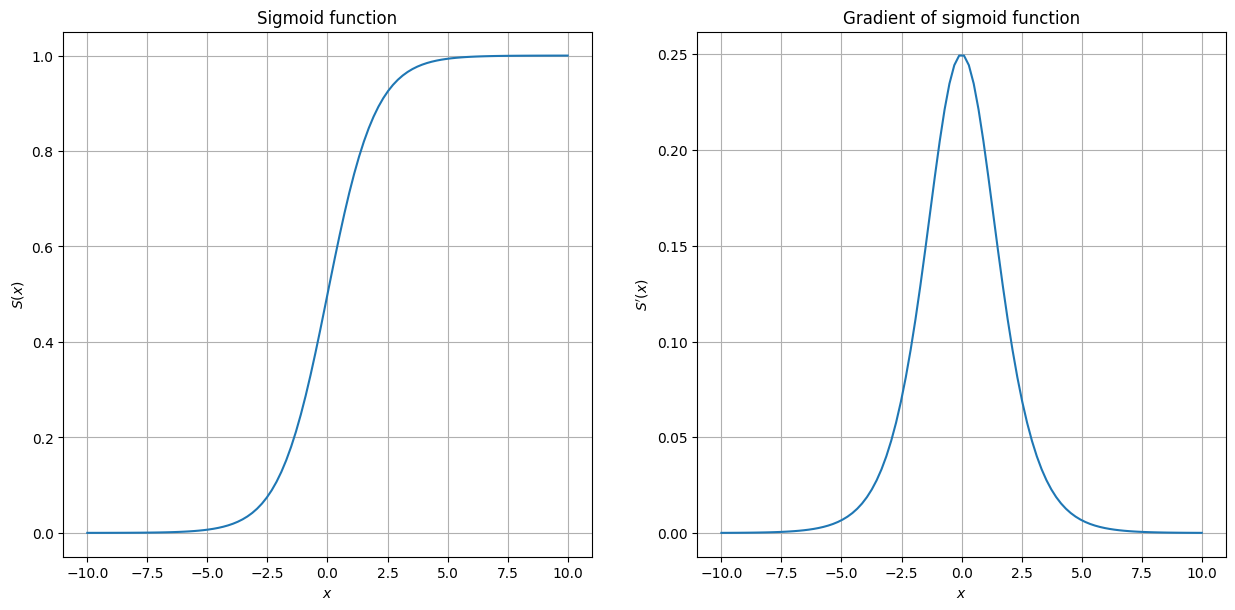

In [ ]:
def sigmoid(input):
  exp = np.exp(-input)
  output = 1./(1.+exp)
  return output

def sigmoid_grad(sigmoid_output):
  return (1.-sigmoid_output)*sigmoid_output #Refer here when implementing activation function in Task 2


def softmax(input):
  exp = np.exp(input)
  denominator = np.sum(exp, axis=1, keepdims=True)
  return exp/denominator

def softmax_grad(softmax_output):
  return np.diag(softmax_output.squeeze()) - np.matmul(softmax_output.T, softmax_output)


inputs = np.linspace(-10, 10, 100)
figure = plt.figure(figsize=(15,15))

f1 = figure.add_subplot(221)
f2 = figure.add_subplot(222)

f1.plot(inputs, sigmoid(inputs))
f1.grid(True)
f1.set_title('Sigmoid function')
f1.set_xlabel('$x$')
f1.set_ylabel('$S(x)$')

f2.plot(inputs, sigmoid_grad(sigmoid(inputs)))
f2.grid(True)
f2.set_title('Gradient of sigmoid function')
f2.set_xlabel('$x$')
f2.set_ylabel('$S\'(x)$')

plt.show()

- Define deep neural network class with following method
  - Initialization of network : `__init__`
  - Forward propagation: `forward`
  - Backpropagation: `backward`
  - Computing loss: `compute_loss`
  - Updating parameters: `update`

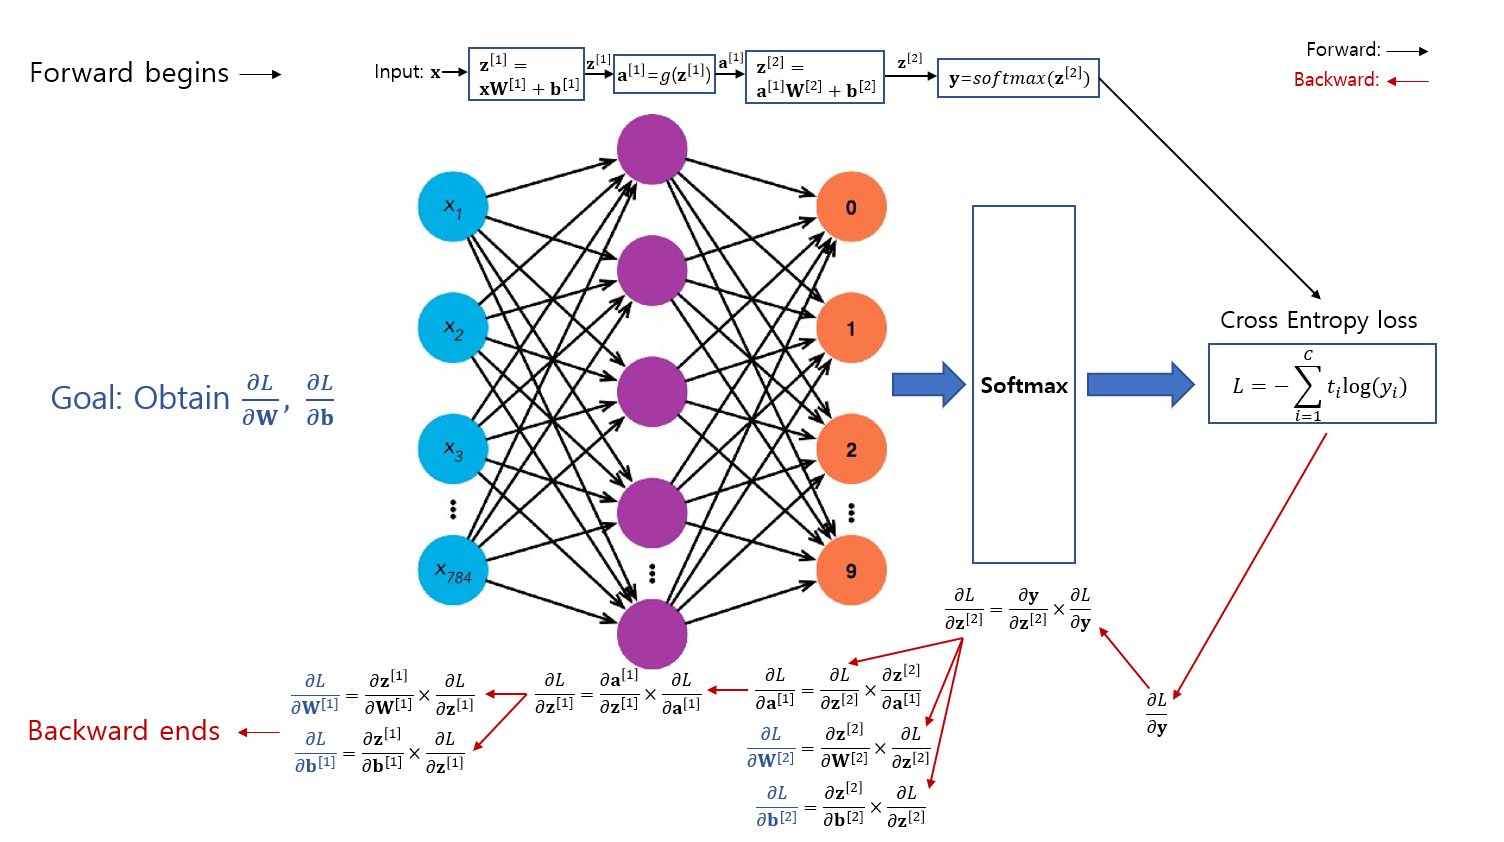

- During forward propagation, the output $\mathbf{y}$ is obtained by the following procedures,

    $\mathbf{z}^{[1]} = \mathbf{x}\mathbf{W}^{[1]} + \mathbf{b}^{[1]}$
    ```python
    self.linear_l1 = np.matmul(input, self.W1) + self.b1
    ```        
    $\mathbf{a}^{[1]} = g(\mathbf{z}^{[1]})$
    ```python
    self.activation_l1 = self.activation(self.linear_l1)
    ```
    $\mathbf{z}^{[2]} = \mathbf{a}^{[1]}\mathbf{W}^{[2]} + \mathbf{b}^{[2]}$
    ```python
    self.linear_l2 = np.matmul(self.activation_l1, self.W2) + self.b2
    ```
    $\mathbb{y} = \mathbf{a}^{[2]} = softmax(\mathbf{z}^{[2]})$
    ```python
    activation_l2 = softmax(self.linear_l2)
    ```

- And we use the cross entropy loss $L = -\sum_{i=1}^{C}t_ilog(y_i)$ where $t$ is indicates a label of one-hot vector type (i.e. if true label is 4, t=[0,0,0,1,0,0,0,0,0,0]. Thus $t_4$=1 and if i is not 4, $t_i$=0),

- The goal of backpropagation step is to obtain $\frac{\partial L}{\partial \mathbf{W}},\frac{\partial L}{\partial \mathbf{b}}$. The following gradients are required in order to obtian the gradient of the parameters.
  - Gradient of $y_i$ is $\frac{\partial L}{\partial y_i}= -\frac{t_i}{y_i}$ \\
  And $\frac{\partial L}{\partial \mathbf{y}} (=\frac{\partial L}{\partial \mathbf{a}^{[2]}})$ is defined as a vector form of $ [\frac{\partial L}{\partial y_1}, \dots, \frac{\partial L}{\partial y_C}]$

    ```python
gradient_activation_l2 = -(target)/(prediction + 1e-9)
    ```

  - Gradient of $z^{[2]}_i$ is $\frac{\partial L}{\partial z^{[2]}_i} = \sum_j{\frac{\partial L}{\partial y_j}\times\frac{\partial y_j}{\partial z^{[2]}_i}}= -\frac{t_i}{y_i}y_i(1-y_i)+ \sum_{j \neq i}\{(-\frac{t_j}{y_j})(-y_iy_j)\} =t_iy_i-t_i + \sum_{j \neq i}t_jy_i = y_i-t_i $

    And $\frac{\partial L}{\partial \mathbf{z}^{[2]}}$ is defined as a vector form of $[\frac{\partial L}{\partial z^{[2]}_1},\dots,\frac{\partial L}{\partial z^{[2]}_C}]$

    ```python
    gradient_linear_l2 = np.matmul(gradient_activation_l2, softmax_grad(prediction))
    ```
 - Gradient of $\mathbf{z}^{[1]}$ is 

    $\frac{\partial L}{\partial \mathbf{z}^{[1]}} = \frac{\partial L}{\partial \mathbf{a}^{[1]}}\times \frac{\partial \mathbf{a}^{[1]}}{\partial \mathbf{z}^{[1]}} =  \frac{\partial L}{\partial \mathbf{a}^{[1]}} \odot g'(\mathbf{z}^{[1]})$ 
    
    ```python
gradient_linear_l1 = gradient_activation_l1 * self.activation_grad(self.activation_l1)
    ```

    where $\frac{\partial L}{\partial \mathbf{a}^{[1]}} = \frac{\partial \mathbf{z}^{[2]}}{\partial \mathbf{a}^{[1]}}\times \frac{\partial L}{\partial \mathbf{z}^{[2]}} = \frac{\partial L}{\partial \mathbf{z}^{[2]}}\times \mathbf{W}^{[2]T}$

    ```python
gradient_activation_l1 = np.matmul(gradient_linear_l2, self.W2.T)
    ```

 - Gradient of weights $\frac{\partial L}{\partial \mathbf{W}}$:
    
    $\frac{\partial L}{\partial \mathbf{W}^{[2]}} = \frac{\partial \mathbf{z}^{[2]}}{\partial \mathbf{W}^{[2]}}\times\frac{\partial L}{\partial \mathbf{z}^{[2]}} = \mathbf{a}^{[1]T}\times\frac{\partial L}{\partial \mathbf{z}^{[2]}}$

    $\frac{\partial L}{\partial \mathbf{W}^{[1]}} = \frac{\partial \mathbf{z}^{[1]}}{\partial \mathbf{W}^{[1]}}\times\frac{\partial L}{\partial \mathbf{z}^{[1]}} = \mathbf{x}^{T}\times\frac{\partial L}{\partial \mathbf{z}^{[1]}}$
 
    ```python
    self.W2_grad = np.matmul(self.activation_l1.T,gradient_linear_l2 )/batchsize
    self.W1_grad = np.matmul(input.T, gradient_linear_l1)/batchsize
    ```

 - Gradient of bias $\frac{\partial L}{\partial \mathbf{b}}$:
 
    $\frac{\partial L}{\partial \mathbf{b}^{[2]}}$ = $\frac{\partial \mathbf{z}^{[2]}}{\partial \mathbf{b}^{[2]}}\times\frac{\partial L}{\partial \mathbf{z}^{[2]}} = \mathbf{1}^T\times\frac{\partial L}{\partial \mathbf{z}^{[2]}}$

    $\frac{\partial L}{\partial \mathbf{b}^{[1]}}$ = $\frac{\partial \mathbf{z}^{[1]}}{\partial \mathbf{b}^{[1]}}\times\frac{\partial L}{\partial \mathbf{z}^{[1]}} = \mathbf{1}^T\times\frac{\partial L}{\partial \mathbf{z}^{[1]}}$

    ```python
self.b2_grad = np.sum(gradient_linear_l2, axis=0)/batchsize
self.b1_grad = np.sum(gradient_linear_l1, axis=0)/batchsize
    ```

In [ ]:
class SingleHIddenMLP:
  def __init__(self, input_size, hidden_layer_size, output_size, activation, activation_grad, learning_rate):
    self.input_size = input_size
    self.hidden_layer_size = hidden_layer_size
    self.output_size = output_size
    self.activation = activation
    self.activation_grad = activation_grad
    self.learning_rate = learning_rate

    # Parameters of 1st layer 
    self.W1 = np.random.normal(size=(self.input_size, self.hidden_layer_size))
    self.b1 = np.random.normal(size=(1, self.hidden_layer_size,)) 

    # Parameters of 2nd layer 
    self.W2 = np.random.normal(size=(self.hidden_layer_size, self.output_size))
    self.b2 = np.random.normal(size=(1, self.output_size)) 

    # Gradients of 1st layer 
    self.W1_grad = np.zeros(shape=(self.input_size, self.hidden_layer_size))
    self.b1_grad = np.zeros(shape=(1, self.hidden_layer_size,)) 

    # Gradients of 2nd layer 
    self.W2_grad = np.zeros(shape=(self.hidden_layer_size, self.output_size))
    self.b2_grad = np.zeros(shape=(1, self.output_size)) 
    
    # Save results of each layers for backpropagation 
    self.linear_l1 = 0
    self.activation_l1 = 0
    self.linear_l2 = 0

  def forward(self,input):
    # Forward propagation
    batchsize = len(input)
    input = input.reshape(batchsize, -1)
    # Propagation through 1st layer 
    self.linear_l1 = np.matmul(input, self.W1) + self.b1
    # Activation in 1st layer 
    self.activation_l1 = self.activation(self.linear_l1)
    # Propagation through 2nd layer 
    self.linear_l2 = np.matmul(self.activation_l1, self.W2) + self.b2
    # Softmax activation for multi-class classification 
    activation_l2 = softmax(self.linear_l2)
    return activation_l2

  def compute_loss(self,prediction, target):
    # Cross-entropy loss for multi-class classification
    loss = target * np.log(prediction)
    loss = - np.sum(loss.flatten())/len(target)
    return loss
  
  def backward(self,prediction, target, input):
    # Backpropagation
    batchsize = len(input)
    input = input.reshape(batchsize, -1)    
    gradient_activation_l2 = -(target)/(prediction + 1e-9)   
    gradient_linear_l2 = np.matmul(gradient_activation_l2, softmax_grad(prediction))
     
    self.W2_grad = np.matmul(self.activation_l1.T,gradient_linear_l2 )/batchsize                # Refer here when implementing linear layer in Task 2
    self.b2_grad = np.sum(gradient_linear_l2, axis=0)/batchsize                                 # Refer here whem implementing linear layer in Task 2
    
    gradient_activation_l1 = np.matmul(gradient_linear_l2, self.W2.T)                           # Refer here when implementing linear layer in Task 2
    gradient_linear_l1 = gradient_activation_l1 * self.activation_grad(self.activation_l1)      # Refer here when implementing activation function in Task 2

    self.W1_grad = np.matmul(input.T, gradient_linear_l1)/batchsize
    self.b1_grad = np.sum(gradient_linear_l1, axis=0)/batchsize
    return

  def update(self):
    # Parameter update via gradient descent 
    self.W1 -= self.learning_rate * self.W1_grad
    self.b1 -= self.learning_rate * self.b1_grad
    self.W2 -= self.learning_rate * self.W2_grad
    self.b2 -= self.learning_rate * self.b2_grad

    self.W1_grad = np.zeros(shape=(self.input_size, self.hidden_layer_size))
    self.b1_grad = np.zeros(shape=(1, self.hidden_layer_size,)) 
    self.W2_grad = np.zeros(shape=(self.hidden_layer_size, self.output_size))
    self.b2_grad = np.zeros(shape=(1, self.output_size)) 

### Train and evaluate a deep neural network
- For Task 1&2, we utilize the MLP as follows:
  - Size of input = 784 (= 28 * 28)
  - Size of hidden layer = 120
  - Size of output = 10 (= number of classes)
- We train the model through 3 epochs, using SGD with learning rate of 0.1



In [ ]:
np.random.seed(0)
model = SingleHIddenMLP(input_size=784, hidden_layer_size=120, output_size=10, activation=sigmoid, activation_grad=sigmoid_grad, learning_rate=0.1)
max_iter = 3
for epoch in tqdm(range(max_iter)):
  indices = np.arange(len(train_images))
  np.random.shuffle(indices)
  train_images_shuffle = train_images[indices]
  train_labels_shuffle = train_labels[indices]
  running_loss = 0.0
  for i in range(len(train_images)):
    input = train_images_shuffle[i:i+1]/255.0
    label = train_labels_shuffle[i:i+1]
    label_onehot = np.eye(10)[label]
    prediction = model.forward(input)
    running_loss += model.compute_loss(prediction, label_onehot)
    model.backward(prediction, label_onehot, input)
    model.update()
  print('Loss = {}'.format(running_loss/len(train_images)))
print('Training Finished')

 33%|███▎      | 1/3 [01:35<03:10, 95.45s/it]

Loss = 0.5012609259579799


 67%|██████▋   | 2/3 [02:52<01:24, 84.47s/it]

Loss = 0.23153933129122573


100%|██████████| 3/3 [04:08<00:00, 82.85s/it]

Loss = 0.166858308157154
Training Finished


Test Accuracy = 94.42


<ipython-input-4-0afdabb8e356>:2: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-input)


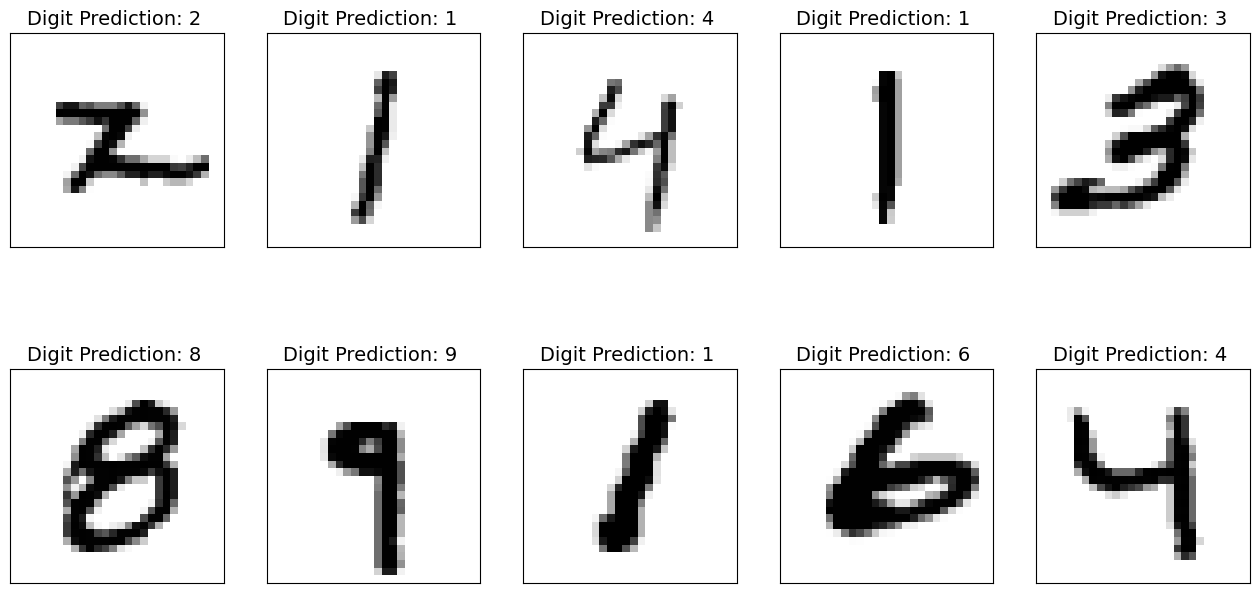

In [ ]:
prediction = model.forward(test_images)
prediction_label = np.argmax(prediction, axis=1)
test_acc = np.sum((prediction_label == test_labels))/len(test_labels)
print('Test Accuracy = {:.2f}'.format(100*test_acc))
# Plotting results
np.random.seed(2023)
idxs = np.random.choice(len(test_labels), 10, replace=False)
plt.figure(figsize=(16, 8))
predict = model.forward(test_images[idxs])
pred_label = np.argmax(predict, axis=1)
for i, idx in enumerate(idxs):
  plt.subplot(2, 5, i + 1)
  plt.imshow(test_images[idx], cmap='gray_r')
  plt.title('Digit Prediction: {} '.format(pred_label[i]), fontsize=14)
  plt.xticks([]); plt.yticks([])

## **Task 2: Implement building blocks of the deep neural network**
- Multi-Layer Perceptron (MLP) is a deep neural network composed only of fully-connected layers (FC layers). 
- In FC layers, following linear operation is performed.

- All linear layers have the same process as follows:
    - 1. Initialize the weight and bias
    - 2. Forward propagation
    - 3. Backpropagation
- So, if we make a class of linear layer, there is no need to calculate the above procedure every time.

In [ ]:
class sigmoid:
  def __init__(self):
    self.output = 0
  
  def forward(self,input):
    exp = np.exp(-input)
    self.output = 1./(1.+exp) # Use this for computing gradient 
    return self.output
  def backward(self, prior_gradient):
################## Write your code here: Compute the gradient of activation layer ###################  
    activation_grad =  (1-self.output)*self.output # Gradient of activation function
    gradient = prior_gradient * activation_grad # Gradient to pass to the previous layer
#####################################################################################################
    return gradient
  
class linear_layer:
  def __init__(self, input_size, output_size):
    self.input_size = input_size
    self.output_size = output_size
    self.weight = np.random.normal(size=(self.input_size, self.output_size))
    self.bias = np.random.normal(size=(1, self.output_size))

    self.weight_grad = np.zeros(shape=(self.input_size, self.output_size))
    self.bias_grad = np.zeros(shape=(1, self.output_size))
    
    self.input = 0
    self.output = 0
  
  def forward(self, input):
    self.input = input # Use this for computing gradient 
    self.output = np.matmul(self.input, self.weight) + self.bias 
    return self.output

  def backward(self, prior_gradient):
    batchsize = len(prior_gradient)
############### Write your code here: Compute the gradient of fully connected layer #################  
    self.weight_grad = np.matmul(self.input.T,prior_gradient )/batchsize # Gradient of weight 
    self.bias_grad = np.sum(prior_gradient, axis=0)/batchsize # Gradient of bias 
    gradient = np.matmul(prior_gradient, self.weight.T) # Gradient to pass to the previous layer
#####################################################################################################
    return gradient

  def update(self, learning_rate):
    self.weight -= learning_rate * self.weight_grad
    self.bias -= learning_rate * self.bias_grad 

    self.weight_grad = np.zeros(shape=(self.input_size, self.output_size))
    self.bias_grad = np.zeros(shape=(1, self.output_size))


class softmax:
  def __init__(self):
    self.output = 0
  
  def forward(self,input):
    exp = np.exp(input)
    denominator = np.sum(exp, axis=1, keepdims=True)
    self.output = exp/denominator # Use this for computing gradient 
    return self.output

  def backward(self, prior_gradient):
    activation_grad = np.diag(self.output.squeeze()) - np.matmul(self.output.T, self.output) # Gradient of softmax function
    gradient = np.matmul(prior_gradient, activation_grad)# Gradient to pass to the previous layer
    return gradient

In [ ]:
class SingleHIddenMLP_block:
  def __init__(self, input_size, hidden_layer_size, output_size, learning_rate):
    self.input_size = input_size
    self.hidden_layer_size = hidden_layer_size
    self.output_size = output_size
    self.learning_rate = learning_rate

    self.linear_layer1 = linear_layer(self.input_size, self.hidden_layer_size)
    self.activation1 = sigmoid() 

    self.linear_layer2 = linear_layer(self.hidden_layer_size, self.output_size)
    self.softmax = softmax()

  def forward(self,input):
    batchsize = len(input)
    input = input.reshape(batchsize, -1)
    linear_l1 = self.linear_layer1.forward(input)
    activation_l1 = self.activation1.forward(linear_l1)

    linear_l2 = self.linear_layer2.forward(activation_l1)
    activation_l2 = self.softmax.forward(linear_l2)

    return activation_l2

  def compute_loss(self,prediction, target):
    loss = target * np.log(prediction)
    loss = - np.sum(loss.flatten())/len(target)
    return loss
  
  def backward(self,prediction, target):
    batchsize = len(input)
    gradient_activation_l2 = -(target)/(prediction + 1e-9)   
    gradient_linear_l2 = self.softmax.backward(gradient_activation_l2)

    gradient_activation_l1= self.linear_layer2.backward(gradient_linear_l2)
    gradient_linear_l1 = self.activation1.backward(gradient_activation_l1)
    _ = self.linear_layer1.backward(gradient_linear_l1)
    return

  def update(self):
    self.linear_layer1.update(self.learning_rate)
    self.linear_layer2.update(self.learning_rate)

### Train and evaluate a deep neural network
- We train the model through 3 epochs, using SGD with learning rate of 0.1



In [ ]:
model = SingleHIddenMLP_block(input_size=784, hidden_layer_size=120, output_size=10, learning_rate=0.1)
max_iter = 3
for epoch in tqdm(range(max_iter)):
  indices = np.arange(len(train_images))
  np.random.shuffle(indices)
  train_images_shuffle = train_images[indices]
  train_labels_shuffle = train_labels[indices]
  running_loss = 0.0
  for i in range(len(train_images)):
    input = train_images_shuffle[i:i+1]/255.0
    label = train_labels_shuffle[i:i+1]
    label_onehot = np.eye(10)[label]
    prediction = model.forward(input)
    running_loss += model.compute_loss(prediction, label_onehot)
    model.backward(prediction, label_onehot)
    model.update()
  print('Loss = {}'.format(running_loss/len(train_images)))
print('Training Finished')

 33%|███▎      | 1/3 [01:22<02:44, 82.01s/it]

Loss = 0.5225007967701597


 67%|██████▋   | 2/3 [02:42<01:20, 80.90s/it]

Loss = 0.25927548200984396


100%|██████████| 3/3 [04:04<00:00, 81.44s/it]

Loss = 0.1925938745617483
Training Finished


<ipython-input-8-a31e02e5eb40>:6: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-input)


Test Accuracy = 92.63


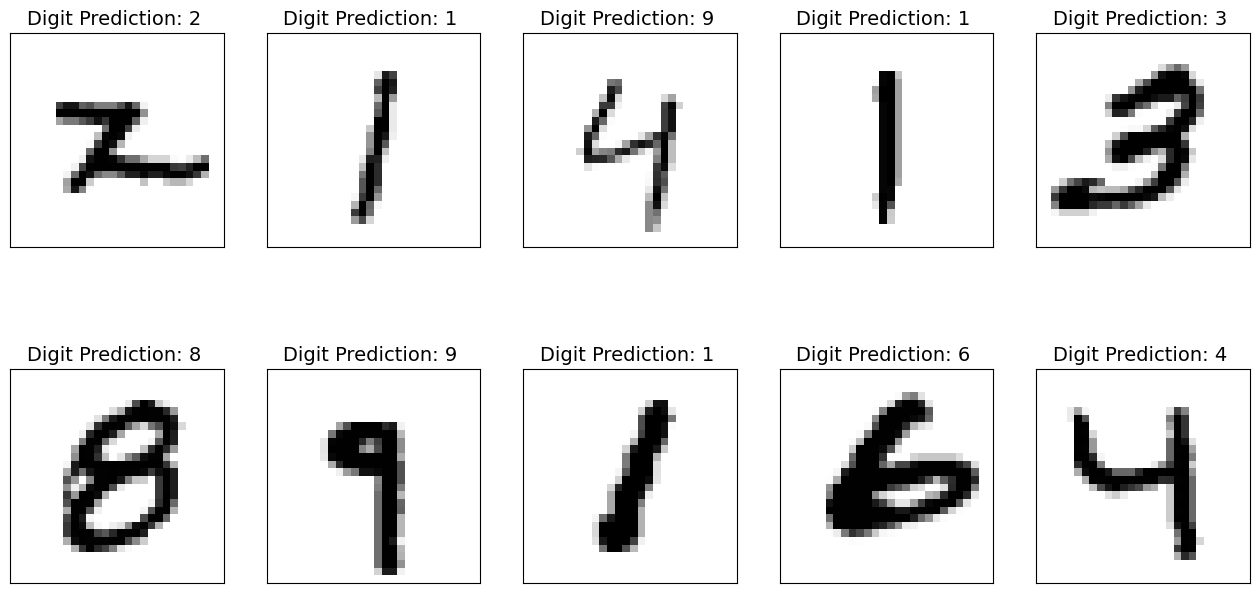

In [ ]:
prediction = model.forward(test_images)
prediction_label = np.argmax(prediction, axis=1)
test_acc = np.sum((prediction_label == test_labels))/len(test_labels)
print('Test Accuracy = {:.2f}'.format(100*test_acc))
# Plotting results
np.random.seed(2023)
idxs = np.random.choice(len(test_labels), 10, replace=False)
plt.figure(figsize=(16, 8))
predict = model.forward(test_images[idxs])
pred_label = np.argmax(predict, axis=1)
for i, idx in enumerate(idxs):
  plt.subplot(2, 5, i + 1)
  plt.imshow(test_images[idx], cmap='gray_r')
  plt.title('Digit Prediction: {} '.format(pred_label[i]), fontsize=14)
  plt.xticks([]); plt.yticks([])

## **Task 3: (Optional): Deep neural network with two hidden layers**
- Using the building blocks defined in Task 2, we can easily define the deep neural network with more hidden layers
- In this experiment, we define the MLP with 2 hidden layers.


In [ ]:
class DoubleHIddenMLP:
  def __init__(self, input_size, hidden_layer_size1, hidden_layer_size2, output_size, learning_rate):
    self.input_size = input_size
    self.hidden_layer_size1= hidden_layer_size1
    self.hidden_layer_size2= hidden_layer_size2
    self.output_size = output_size
    self.learning_rate = learning_rate

    self.linear_layer1 = linear_layer(self.input_size, self.hidden_layer_size1)
    self.activation1 = sigmoid() 
    self.linear_layer2 = linear_layer(self.hidden_layer_size1, self.hidden_layer_size2)
    self.activation2 = sigmoid()
    self.linear_layer3 = linear_layer(self.hidden_layer_size2, self.output_size)
    self.softmax = softmax()
  def forward(self,input):
    batchsize = len(input)
    input = input.reshape(batchsize, -1)
    linear_l1 = self.linear_layer1.forward(input)
    activation_l1 = self.activation1.forward(linear_l1)

    linear_l2 = self.linear_layer2.forward(activation_l1)
    activation_l2 = self.activation2.forward(linear_l2)
    
    linear_l3 = self.linear_layer3.forward(activation_l2)
    activation_l3 = self.softmax.forward(linear_l3)

    return activation_l3

  def compute_loss(self,prediction, target):
    loss = target * np.log(prediction)
    loss = - np.sum(loss.flatten())/len(target)
    return loss
  
  def backward(self,prediction, target):
    batchsize = len(input)
    gradient_activation_l3 = -(target)/(prediction + 1e-9)   
    gradient_linear_l3 = self.softmax.backward(gradient_activation_l3)

    gradient_activation_l2 = self.linear_layer3.backward(gradient_linear_l3)
    gradient_linear_l2 = self.activation2.backward(gradient_activation_l2)
  
    gradient_activation_l1= self.linear_layer2.backward(gradient_linear_l2)
    gradient_linear_l1 = self.activation1.backward(gradient_activation_l1)
    _ = self.linear_layer1.backward(gradient_linear_l1)
    return

  def update(self):
    self.linear_layer1.update(self.learning_rate)
    self.linear_layer2.update(self.learning_rate)
    self.linear_layer3.update(self.learning_rate)

### Train and evaluate a deep neural network with 2 hidden layers
- For Task 1&2, we utilize the MLP as follows:
  - Size of input = 784 (= 28 * 28)
  - Size of 1st hidden layer = 240
  - Size of 2nd hidden layer = 120
  - Size of output = 10 (= number of classes)
- We train the model through 3 epochs, using SGD with learning rate of 0.1
- **Note**: Deeper network requires more training epoches and longer training time. When trained with 3 epoches, MLP with 2 hidden layers may work worse than the MLP with 1 hidden layer. One may try to compare the performances of different models with more training epoches, if interested.

In [ ]:
model = DoubleHIddenMLP(input_size=784, hidden_layer_size1=240, hidden_layer_size2=120, output_size=10, learning_rate=0.1)
max_iter = 3
for epoch in tqdm(range(max_iter)):
  indices = np.arange(len(train_images))
  np.random.shuffle(indices)
  train_images_shuffle = train_images[indices]
  train_labels_shuffle = train_labels[indices]
  running_loss = 0.0
  for i in range(len(train_images)):
    input = train_images_shuffle[i:i+1]/255.0
    label = train_labels_shuffle[i:i+1]
    label_onehot = np.eye(10)[label]
    prediction = model.forward(input)
    running_loss += model.compute_loss(prediction, label_onehot)
    model.backward(prediction, label_onehot)
    model.update()
  print('Loss = {}'.format(running_loss/len(train_images)))

print('Training Finished')

 33%|███▎      | 1/3 [02:46<05:33, 166.95s/it]

Loss = 0.6504818619888016


 67%|██████▋   | 2/3 [05:32<02:45, 165.96s/it]

Loss = 0.3340610409038155


100%|██████████| 3/3 [08:17<00:00, 165.87s/it]

Loss = 0.2510317659220185
Training Finished


<ipython-input-8-a31e02e5eb40>:6: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-input)


Test Accuracy = 92.73


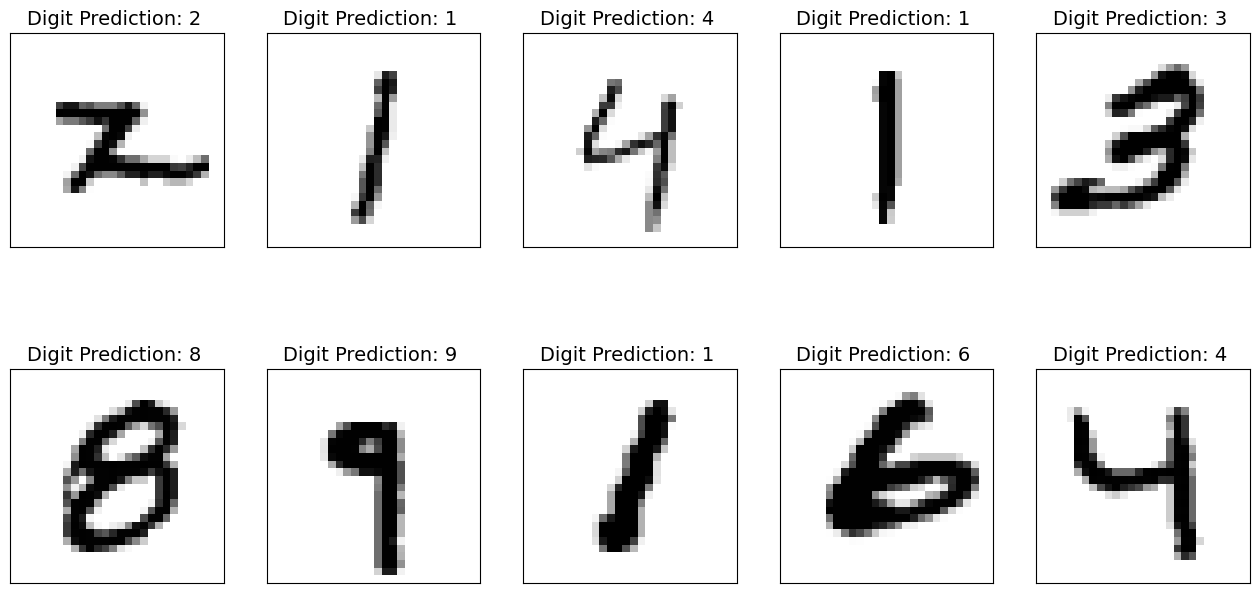

In [ ]:
prediction = model.forward(test_images)
prediction_label = np.argmax(prediction, axis=1)
test_acc = np.sum((prediction_label == test_labels))/len(test_labels)
print('Test Accuracy = {:.2f}'.format(100*test_acc))
# Plotting results
np.random.seed(2023)
idxs = np.random.choice(len(test_labels), 10, replace=False)
plt.figure(figsize=(16, 8))
predict = model.forward(test_images[idxs])
pred_label = np.argmax(predict, axis=1)
for i, idx in enumerate(idxs):
  plt.subplot(2, 5, i + 1)
  plt.imshow(test_images[idx], cmap='gray_r')
  plt.title('Digit Prediction: {} '.format(pred_label[i]), fontsize=14)
  plt.xticks([]); plt.yticks([])